In [1]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet
from glob import glob
import scipy.misc

Using TensorFlow backend.


In [2]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# with open('sim-data-capture/sim_data_large.yaml', 'r') as f:
#     df = pd.io.json.json_normalize(yaml.load(f))

# def parse_values(val):

#     if len(val) == 0:
#         return 'noColor'
#     else:
#         return (val[0]['class'])
    
# df['color'] = df.annotations.map(parse_values)
# df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
image_shape = (227,227)

shutil.rmtree('data/train/')
shutil.rmtree('data/valid/')
os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/green')
os.mkdir('data/train/red')
os.mkdir('data/train/yellow')
os.mkdir('data/train/unknown')

os.mkdir('data/valid/green')
os.mkdir('data/valid/red')
os.mkdir('data/valid/yellow')
os.mkdir('data/valid/unknown')

for color in ['green','yellow','red','unknown']:
    
    files_simulator = glob('BiggerTrainingData/'+color+'/*.jpeg')
    np.random.shuffle(files_simulator)
    files_simulator = files_simulator[:int(0.35*len(files_simulator))]#data imbalance. only select 25% of the files
    print('Simulator '+color, len(files_simulator))

    files_real =glob('real_training_data/'+color+'/*.jpg')
    print('Real_Training '+color, len(files_real))
    files = files_simulator + files_real

    for filename in files:
        #print(filename)
        if np.random.rand(1)[0] < 0.8:
            directory = 'data/train/'+color+'/'

            shutil.copy(src= filename, dst=directory)
            
            path = os.path.join(directory, filename.split('/')[-1])
            imgg = scipy.misc.imresize(scipy.misc.imread(path), image_shape)# so data generator don't resize everytime
            scipy.misc.imsave(path,imgg[:,:,:3])
        else:    
            directory = 'data/valid/'+color+'/'
            shutil.copy(src= filename, dst=directory)
            
            path = os.path.join(directory, filename.split('/')[-1])
            imgg = scipy.misc.imresize(scipy.misc.imread(path), image_shape)
            scipy.misc.imsave(path,imgg[:,:,:3])


('Simulator green', 363)
('Real_Training green', 325)
('Simulator yellow', 337)
('Real_Training yellow', 131)
('Simulator red', 349)
('Real_Training red', 186)
('Simulator unknown', 381)
('Real_Training unknown', 62)


In [5]:
img_width, img_height = 227, 227
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 1024
nb_validation_samples = 256 
batch_size = 16
epochs = 100

In [6]:
#training data generator
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [7]:
#validation data generator
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)


In [8]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 1734 images belonging to 4 classes.


In [9]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 

class_mode = "categorical")

Found 400 images belonging to 4 classes.


In [10]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output
#reducing the size through convolutions so parameters stay reasonable
x = Dropout(0.5, name='drop9')(x)
x = Convolution2D(400, kernel_size=(3, 3), strides=(2,2), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00004), metrics=["accuracy"])


In [11]:
#model_final.summary()

### First 200 Epochs of training

In [12]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 250,# nb_train_samples/batch_size,
epochs = 600,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/600
250/250 [==============================] - 7s - loss: 3.4801 - acc: 0.2814 - val_loss: 1.3856 - val_acc: 0.3065
Epoch 2/600
250/250 [==============================] - 7s - loss: 1.6221 - acc: 0.2636 - val_loss: 1.3720 - val_acc: 0.3871
Epoch 3/600
250/250 [==============================] - 7s - loss: 1.4615 - acc: 0.2746 - val_loss: 1.3863 - val_acc: 0.2417
Epoch 4/600
250/250 [==============================] - 7s - loss: 1.4136 - acc: 0.2894 - val_loss: 1.3795 - val_acc: 0.3185
Epoch 5/600
250/250 [==============================] - 7s - loss: 1.3973 - acc: 0.2951 - val_loss: 1.3758 - val_acc: 0.3085
Epoch 6/600
250/250 [==============================] - 7s - loss: 1.3926 - acc: 0.3062 - val_loss: 1.3694 - val_acc: 0.3649
Epoch 7/600
250/250 [==============================] - 7s - loss: 1.3844 - acc: 0.3082 - val_loss: 1.3820 - val_acc: 0.3125
Epoch 8/600
250/250 [==============================] - 7s - loss: 1.3818 - acc: 0.3016 - val_loss: 1.3790 - val_acc: 0.3024
Epoch 9/

250/250 [==============================] - 7s - loss: 0.6197 - acc: 0.7364 - val_loss: 0.5048 - val_acc: 0.7520
Epoch 67/600
250/250 [==============================] - 7s - loss: 0.5953 - acc: 0.7451 - val_loss: 0.5498 - val_acc: 0.7480
Epoch 68/600
250/250 [==============================] - 7s - loss: 0.5894 - acc: 0.7457 - val_loss: 0.4979 - val_acc: 0.7625
Epoch 69/600
250/250 [==============================] - 7s - loss: 0.5902 - acc: 0.7482 - val_loss: 0.4376 - val_acc: 0.8065
Epoch 70/600
250/250 [==============================] - 7s - loss: 0.5550 - acc: 0.7616 - val_loss: 0.4986 - val_acc: 0.7500
Epoch 71/600
250/250 [==============================] - 7s - loss: 0.5441 - acc: 0.7682 - val_loss: 0.4436 - val_acc: 0.7702
Epoch 72/600
250/250 [==============================] - 7s - loss: 0.5284 - acc: 0.7714 - val_loss: 0.4230 - val_acc: 0.7863
Epoch 73/600
250/250 [==============================] - 7s - loss: 0.5254 - acc: 0.7784 - val_loss: 0.3986 - val_acc: 0.8042
Epoch 74/600


250/250 [==============================] - 7s - loss: 0.2196 - acc: 0.9041 - val_loss: 0.1544 - val_acc: 0.9274
Epoch 132/600
250/250 [==============================] - 7s - loss: 0.2260 - acc: 0.9032 - val_loss: 0.2060 - val_acc: 0.9113
Epoch 133/600
250/250 [==============================] - 7s - loss: 0.2079 - acc: 0.9092 - val_loss: 0.1509 - val_acc: 0.9375
Epoch 134/600
250/250 [==============================] - 7s - loss: 0.2145 - acc: 0.9030 - val_loss: 0.1423 - val_acc: 0.9479
Epoch 135/600
250/250 [==============================] - 7s - loss: 0.2097 - acc: 0.9062 - val_loss: 0.2014 - val_acc: 0.9093
Epoch 136/600
250/250 [==============================] - 7s - loss: 0.2255 - acc: 0.9018 - val_loss: 0.2015 - val_acc: 0.9254
Epoch 137/600
250/250 [==============================] - 7s - loss: 0.2058 - acc: 0.9054 - val_loss: 0.1749 - val_acc: 0.9294
Epoch 138/600
250/250 [==============================] - 7s - loss: 0.2071 - acc: 0.9051 - val_loss: 0.1419 - val_acc: 0.9435
Epoch 

250/250 [==============================] - 7s - loss: 0.1397 - acc: 0.9405 - val_loss: 0.1295 - val_acc: 0.9479
Epoch 197/600
250/250 [==============================] - 7s - loss: 0.1364 - acc: 0.9382 - val_loss: 0.1419 - val_acc: 0.9375
Epoch 198/600
250/250 [==============================] - 7s - loss: 0.1328 - acc: 0.9416 - val_loss: 0.1056 - val_acc: 0.9597
Epoch 199/600
250/250 [==============================] - 7s - loss: 0.1354 - acc: 0.9372 - val_loss: 0.1533 - val_acc: 0.9667
Epoch 200/600
250/250 [==============================] - 7s - loss: 0.1247 - acc: 0.9441 - val_loss: 0.0782 - val_acc: 0.9718
Epoch 201/600
250/250 [==============================] - 7s - loss: 0.1288 - acc: 0.9402 - val_loss: 0.1545 - val_acc: 0.9617
Epoch 202/600
250/250 [==============================] - 7s - loss: 0.1328 - acc: 0.9413 - val_loss: 0.1745 - val_acc: 0.9476
Epoch 203/600
250/250 [==============================] - 7s - loss: 0.1420 - acc: 0.9382 - val_loss: 0.1192 - val_acc: 0.9617
Epoch 

250/250 [==============================] - 7s - loss: 0.1001 - acc: 0.9610 - val_loss: 0.1003 - val_acc: 0.9698
Epoch 262/600
250/250 [==============================] - 7s - loss: 0.1134 - acc: 0.9515 - val_loss: 0.1214 - val_acc: 0.9577
Epoch 263/600
250/250 [==============================] - 7s - loss: 0.1020 - acc: 0.9550 - val_loss: 0.1169 - val_acc: 0.9458
Epoch 264/600
250/250 [==============================] - 7s - loss: 0.0992 - acc: 0.9595 - val_loss: 0.0964 - val_acc: 0.9637
Epoch 265/600
250/250 [==============================] - 7s - loss: 0.0971 - acc: 0.9560 - val_loss: 0.1198 - val_acc: 0.9415
Epoch 266/600
250/250 [==============================] - 7s - loss: 0.1008 - acc: 0.9555 - val_loss: 0.1118 - val_acc: 0.9556
Epoch 267/600
250/250 [==============================] - 7s - loss: 0.1033 - acc: 0.9538 - val_loss: 0.0991 - val_acc: 0.9637
Epoch 268/600
250/250 [==============================] - 7s - loss: 0.1014 - acc: 0.9583 - val_loss: 0.1254 - val_acc: 0.9521
Epoch 

250/250 [==============================] - 7s - loss: 0.0887 - acc: 0.9621 - val_loss: 0.0939 - val_acc: 0.9758
Epoch 327/600
250/250 [==============================] - 7s - loss: 0.0766 - acc: 0.9676 - val_loss: 0.1086 - val_acc: 0.9758
Epoch 328/600
250/250 [==============================] - 7s - loss: 0.0761 - acc: 0.9690 - val_loss: 0.0901 - val_acc: 0.9625
Epoch 329/600
250/250 [==============================] - 7s - loss: 0.0851 - acc: 0.9652 - val_loss: 0.0812 - val_acc: 0.9617
Epoch 330/600
250/250 [==============================] - 7s - loss: 0.0882 - acc: 0.9637 - val_loss: 0.1210 - val_acc: 0.9597
Epoch 331/600
250/250 [==============================] - 7s - loss: 0.0758 - acc: 0.9695 - val_loss: 0.1346 - val_acc: 0.9698
Epoch 332/600
250/250 [==============================] - 7s - loss: 0.0841 - acc: 0.9622 - val_loss: 0.0931 - val_acc: 0.9657
Epoch 333/600
250/250 [==============================] - 7s - loss: 0.0837 - acc: 0.9667 - val_loss: 0.0811 - val_acc: 0.9854
Epoch 

250/250 [==============================] - 7s - loss: 0.0726 - acc: 0.9725 - val_loss: 0.0884 - val_acc: 0.9819
Epoch 392/600
250/250 [==============================] - 7s - loss: 0.0581 - acc: 0.9761 - val_loss: 0.0463 - val_acc: 0.9899
Epoch 393/600
250/250 [==============================] - 7s - loss: 0.0590 - acc: 0.9777 - val_loss: 0.1065 - val_acc: 0.9750
Epoch 394/600
250/250 [==============================] - 7s - loss: 0.0646 - acc: 0.9746 - val_loss: 0.0445 - val_acc: 0.9879
Epoch 395/600
250/250 [==============================] - 7s - loss: 0.0620 - acc: 0.9745 - val_loss: 0.0990 - val_acc: 0.9758
Epoch 396/600
250/250 [==============================] - 7s - loss: 0.0609 - acc: 0.9748 - val_loss: 0.0909 - val_acc: 0.9792
Epoch 397/600
250/250 [==============================] - 7s - loss: 0.0605 - acc: 0.9760 - val_loss: 0.0757 - val_acc: 0.9839
Epoch 398/600
250/250 [==============================] - 7s - loss: 0.0690 - acc: 0.9735 - val_loss: 0.0770 - val_acc: 0.9819
Epoch 

250/250 [==============================] - 7s - loss: 0.0545 - acc: 0.9777 - val_loss: 0.0991 - val_acc: 0.9798
Epoch 457/600
250/250 [==============================] - 7s - loss: 0.0557 - acc: 0.9772 - val_loss: 0.0796 - val_acc: 0.9778
Epoch 458/600
250/250 [==============================] - 7s - loss: 0.0544 - acc: 0.9772 - val_loss: 0.1073 - val_acc: 0.9819
Epoch 459/600
250/250 [==============================] - 7s - loss: 0.0507 - acc: 0.9795 - val_loss: 0.0671 - val_acc: 0.9798
Epoch 460/600
250/250 [==============================] - 7s - loss: 0.0562 - acc: 0.9810 - val_loss: 0.1224 - val_acc: 0.9718
Epoch 461/600
250/250 [==============================] - 7s - loss: 0.0565 - acc: 0.9801 - val_loss: 0.1731 - val_acc: 0.9637
Epoch 462/600
250/250 [==============================] - 7s - loss: 0.0582 - acc: 0.9785 - val_loss: 0.1045 - val_acc: 0.9812
Epoch 463/600
250/250 [==============================] - 7s - loss: 0.0496 - acc: 0.9792 - val_loss: 0.0983 - val_acc: 0.9798
Epoch 

250/250 [==============================] - 7s - loss: 0.0386 - acc: 0.9842 - val_loss: 0.0828 - val_acc: 0.9833
Epoch 522/600
250/250 [==============================] - 7s - loss: 0.0497 - acc: 0.9845 - val_loss: 0.0653 - val_acc: 0.9819
Epoch 523/600
250/250 [==============================] - 7s - loss: 0.0478 - acc: 0.9797 - val_loss: 0.0922 - val_acc: 0.9798
Epoch 524/600
250/250 [==============================] - 7s - loss: 0.0356 - acc: 0.9863 - val_loss: 0.0905 - val_acc: 0.9771
Epoch 525/600
250/250 [==============================] - 7s - loss: 0.0544 - acc: 0.9814 - val_loss: 0.1241 - val_acc: 0.9758
Epoch 526/600
250/250 [==============================] - 7s - loss: 0.0539 - acc: 0.9822 - val_loss: 0.0856 - val_acc: 0.9798
Epoch 527/600
250/250 [==============================] - 7s - loss: 0.0464 - acc: 0.9826 - val_loss: 0.0829 - val_acc: 0.9854
Epoch 528/600
250/250 [==============================] - 7s - loss: 0.0341 - acc: 0.9880 - val_loss: 0.1117 - val_acc: 0.9798
Epoch 

250/250 [==============================] - 7s - loss: 0.0400 - acc: 0.9863 - val_loss: 0.1012 - val_acc: 0.9758
Epoch 587/600
250/250 [==============================] - 7s - loss: 0.0374 - acc: 0.9882 - val_loss: 0.0853 - val_acc: 0.9839
Epoch 588/600
250/250 [==============================] - 7s - loss: 0.0417 - acc: 0.9848 - val_loss: 0.0824 - val_acc: 0.9792
Epoch 589/600
250/250 [==============================] - 7s - loss: 0.0443 - acc: 0.9821 - val_loss: 0.1174 - val_acc: 0.9839
Epoch 590/600
250/250 [==============================] - 7s - loss: 0.0363 - acc: 0.9872 - val_loss: 0.0566 - val_acc: 0.9879
Epoch 591/600
250/250 [==============================] - 7s - loss: 0.0374 - acc: 0.9857 - val_loss: 0.0640 - val_acc: 0.9875
Epoch 592/600
250/250 [==============================] - 7s - loss: 0.0369 - acc: 0.9865 - val_loss: 0.0489 - val_acc: 0.9819
Epoch 593/600
250/250 [==============================] - 7s - loss: 0.0458 - acc: 0.9833 - val_loss: 0.0795 - val_acc: 0.9899
Epoch 

### Another 200 Epochs of training

In [13]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 250,# nb_train_samples/batch_size,
epochs = 200,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/200
250/250 [==============================] - 7s - loss: 0.0407 - acc: 0.9840 - val_loss: 0.0882 - val_acc: 0.9812
Epoch 2/200
250/250 [==============================] - 7s - loss: 0.0328 - acc: 0.9876 - val_loss: 0.0809 - val_acc: 0.9798
Epoch 3/200
250/250 [==============================] - 7s - loss: 0.0373 - acc: 0.9875 - val_loss: 0.1430 - val_acc: 0.9758
Epoch 4/200
250/250 [==============================] - 7s - loss: 0.0412 - acc: 0.9857 - val_loss: 0.0887 - val_acc: 0.9792
Epoch 5/200
250/250 [==============================] - 7s - loss: 0.0484 - acc: 0.9852 - val_loss: 0.0840 - val_acc: 0.9819
Epoch 6/200
250/250 [==============================] - 7s - loss: 0.0385 - acc: 0.9866 - val_loss: 0.0802 - val_acc: 0.9798
Epoch 7/200
250/250 [==============================] - 7s - loss: 0.0336 - acc: 0.9870 - val_loss: 0.0864 - val_acc: 0.9798
Epoch 8/200
250/250 [==============================] - 7s - loss: 0.0340 - acc: 0.9857 - val_loss: 0.1250 - val_acc: 0.9859
Epoch 9/

250/250 [==============================] - 7s - loss: 0.0290 - acc: 0.9900 - val_loss: 0.1264 - val_acc: 0.9798
Epoch 67/200
250/250 [==============================] - 7s - loss: 0.0263 - acc: 0.9897 - val_loss: 0.0954 - val_acc: 0.9778
Epoch 68/200
250/250 [==============================] - 7s - loss: 0.0382 - acc: 0.9863 - val_loss: 0.0570 - val_acc: 0.9854
Epoch 69/200
250/250 [==============================] - 7s - loss: 0.0376 - acc: 0.9870 - val_loss: 0.0997 - val_acc: 0.9778
Epoch 70/200
250/250 [==============================] - 7s - loss: 0.0356 - acc: 0.9853 - val_loss: 0.1139 - val_acc: 0.9819
Epoch 71/200
250/250 [==============================] - 7s - loss: 0.0336 - acc: 0.9881 - val_loss: 0.0937 - val_acc: 0.9812
Epoch 72/200
250/250 [==============================] - 7s - loss: 0.0305 - acc: 0.9887 - val_loss: 0.0637 - val_acc: 0.9798
Epoch 73/200
250/250 [==============================] - 7s - loss: 0.0374 - acc: 0.9872 - val_loss: 0.1116 - val_acc: 0.9819
Epoch 74/200


250/250 [==============================] - 7s - loss: 0.0336 - acc: 0.9902 - val_loss: 0.0901 - val_acc: 0.9798
Epoch 132/200
250/250 [==============================] - 7s - loss: 0.0320 - acc: 0.9895 - val_loss: 0.0883 - val_acc: 0.9729
Epoch 133/200
250/250 [==============================] - 7s - loss: 0.0301 - acc: 0.9892 - val_loss: 0.0878 - val_acc: 0.9839
Epoch 134/200
250/250 [==============================] - 7s - loss: 0.0313 - acc: 0.9898 - val_loss: 0.0816 - val_acc: 0.9798
Epoch 135/200
250/250 [==============================] - 7s - loss: 0.0293 - acc: 0.9900 - val_loss: 0.0845 - val_acc: 0.9859
Epoch 136/200
250/250 [==============================] - 7s - loss: 0.0310 - acc: 0.9897 - val_loss: 0.1084 - val_acc: 0.9778
Epoch 137/200
250/250 [==============================] - 7s - loss: 0.0291 - acc: 0.9905 - val_loss: 0.1125 - val_acc: 0.9812
Epoch 138/200
250/250 [==============================] - 7s - loss: 0.0372 - acc: 0.9890 - val_loss: 0.0468 - val_acc: 0.9819
Epoch 

250/250 [==============================] - 7s - loss: 0.0363 - acc: 0.9882 - val_loss: 0.1345 - val_acc: 0.9798
Epoch 197/200
250/250 [==============================] - 7s - loss: 0.0293 - acc: 0.9890 - val_loss: 0.0739 - val_acc: 0.9812
Epoch 198/200
250/250 [==============================] - 7s - loss: 0.0238 - acc: 0.9920 - val_loss: 0.0811 - val_acc: 0.9839
Epoch 199/200
250/250 [==============================] - 7s - loss: 0.0251 - acc: 0.9887 - val_loss: 0.0898 - val_acc: 0.9819
Epoch 200/200
250/250 [==============================] - 7s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.1059 - val_acc: 0.9729


### Another 50 Epochs of training

In [14]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 250,# nb_train_samples/batch_size,
epochs = 50,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/50
250/250 [==============================] - 7s - loss: 0.0257 - acc: 0.9926 - val_loss: 0.0886 - val_acc: 0.9839
Epoch 2/50
250/250 [==============================] - 7s - loss: 0.0324 - acc: 0.9880 - val_loss: 0.0993 - val_acc: 0.9819
Epoch 3/50
250/250 [==============================] - 7s - loss: 0.0278 - acc: 0.9910 - val_loss: 0.0720 - val_acc: 0.9839
Epoch 4/50
250/250 [==============================] - 7s - loss: 0.0214 - acc: 0.9917 - val_loss: 0.1496 - val_acc: 0.9677
Epoch 5/50
250/250 [==============================] - 7s - loss: 0.0320 - acc: 0.9902 - val_loss: 0.1712 - val_acc: 0.9729
Epoch 6/50
250/250 [==============================] - 7s - loss: 0.0409 - acc: 0.9872 - val_loss: 0.0668 - val_acc: 0.9859
Epoch 7/50
250/250 [==============================] - 7s - loss: 0.0344 - acc: 0.9892 - val_loss: 0.1228 - val_acc: 0.9819
Epoch 8/50
250/250 [==============================] - 7s - loss: 0.0322 - acc: 0.9890 - val_loss: 0.1119 - val_acc: 0.9771
Epoch 9/50
250/2

### Saved the model

In [15]:

models_folder_path = ''
model_name = 'squeezenet_transfer_learned_real_and_simulator'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

# serialize model to JSON
model_json = model_final.to_json()
with open(arch_path, "w") as json_file:
    json_file.write(model_json)
print('Model architecture saved: ' + arch_path)
    
# serialize weights to HDF5
model_final.save_weights(weights_path)
print('Weights saved: ' + weights_path)

model.save('model_checkpoint.h5')
print('Model checkpoint saved: model_checkpoint.h5')

Model architecture saved: squeezenet_transfer_learned_real_and_simulator_architecture.json
Weights saved: squeezenet_transfer_learned_real_and_simulator_weights.h5
Model checkpoint saved: model_checkpoint.h5


### Load the model

In [16]:

models_folder_path = ''
model_name = 'squeezenet_transfer_learned_real_and_simulator'

arch_path = models_folder_path + model_name + "_architecture.json"
weights_path = models_folder_path + model_name + "_weights.h5"

In [17]:
from keras.models import model_from_json

# load architecture
json_file = open(arch_path)
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights
loaded_model.load_weights(weights_path)

print("Model loaded")

Model loaded


### Check loaded model

In [18]:

validation_generator = train_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

images, labels = next(validation_generator)
print('Validation samples: {}'.format(len(labels)))

Found 400 images belonging to 4 classes.
Validation samples: 32


In [19]:
# #to check one category of images
# images = []
# for img in glob('data/valid/Yellow/*.jpeg'):
#     images.append(scipy.misc.imread(img)/255.0)
    

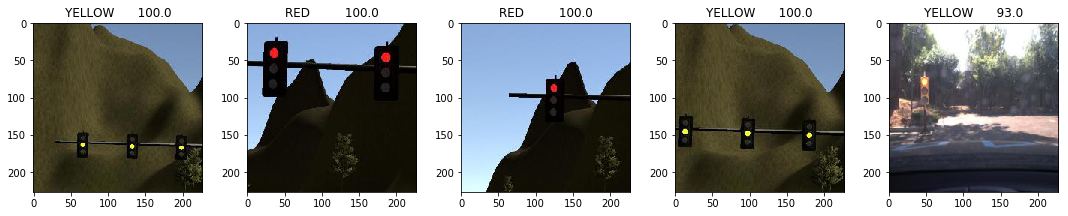

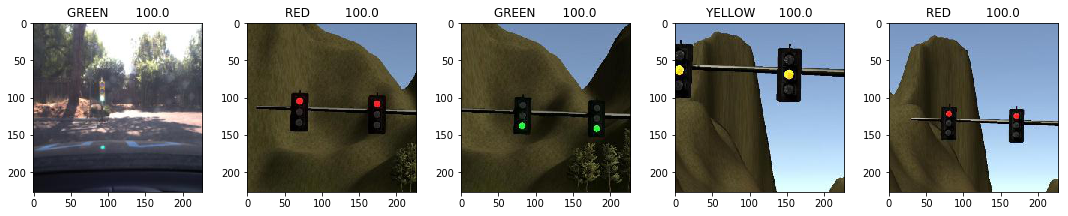

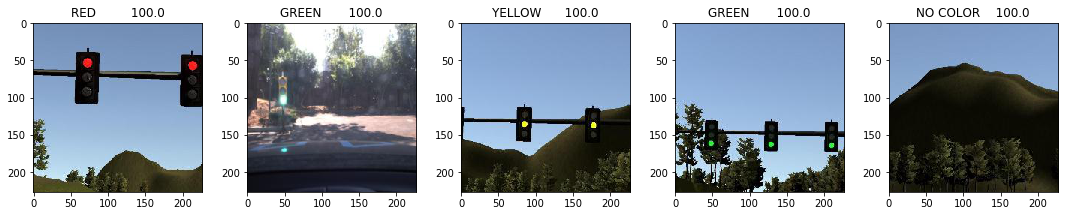

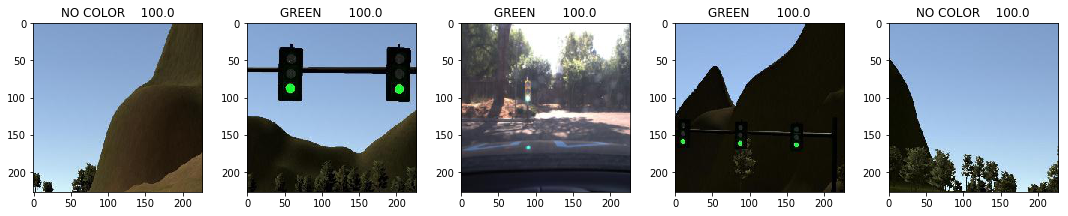

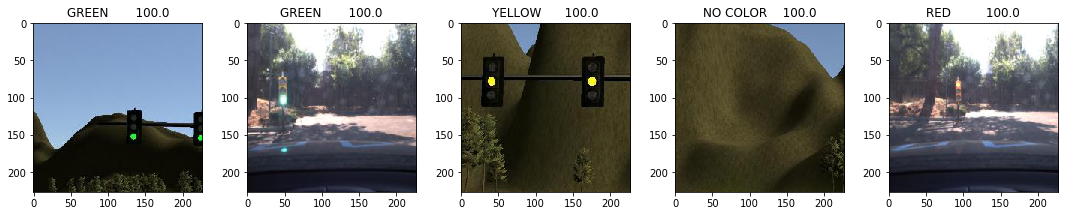

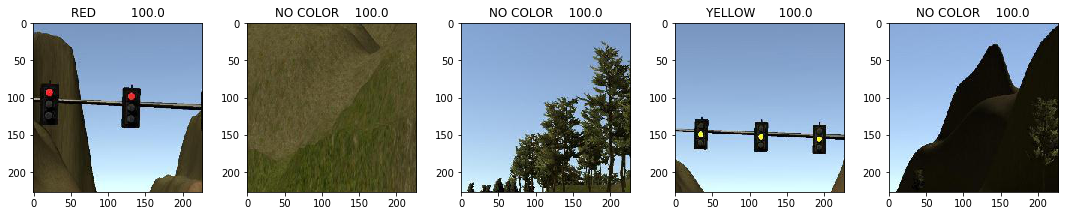

In [20]:
# traffic_light_states = ['GREEN', 'RED', 'YELLOW', 'NO COLOR']
# For some reason No color and Yellow were in the wrong order.
traffic_light_states = ['GREEN', 'RED', 'NO COLOR', 'YELLOW']
for i in range(int(len(images)/5.0)):

    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 6))
    f.tight_layout()
    
    prediction = loaded_model.predict(np.array([images[(5*i) + 0]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax1.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax1.imshow(images[(5*i) + 0])

    prediction = loaded_model.predict(np.array([images[(5*i) + 1]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax2.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax2.imshow(images[(5*i) + 1])

    prediction = loaded_model.predict(np.array([images[(5*i) + 2]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax3.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax3.imshow(images[(5*i) + 2])

    prediction = loaded_model.predict(np.array([images[(5*i) + 3]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax4.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax4.imshow(images[(5*i) + 3])

    prediction = loaded_model.predict(np.array([images[(5*i) + 4]]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]
    ax5.set_title('{0:10}  {1}'.format(prediction_label, np.round(prediction.max()*100.0),2))
    ax5.imshow(images[(5*i) + 4])
